# BootComp Tutorial

This Jupyter _Python 3_ notebook has been written to accompany the `bootcomp` Python package developed by **Christine S.M Currie** and **Tom Monks**, University of Southampton, UK.

The notebook provides a worked example of using `bootcomp` to conduct a two stage screening and search of a simulation model.

## 1. Preamble

### 1.1. Detail of the simulation model

The simulation model was used in a 2017 project in the UK to help a hospital, a community healthcare provider and a clinical commissioning group design and plan a new community rehabilitation ward.  In the UK, patients who require rehabilitation are often stuck in a queuing system where there must wait (inappropriately) in a acute hospital bed for a space in the rehabilitaiton ward.  The model investigated the sizing of the new ward in order to minimise patient waiting time whilst meeting probabilitic constraints regarding ward occupancy (bed utilization) and the number of transfers between single sex bays.

<img src="images/DToC.jpg" alt="Delayed Transfers of Care Model" title="Simulation Model and KPIs" />

### 1.2. Output data

The output data for the example analysis are bundled with git repository.  There are three .csv files in the data/ directory for 'waiting times', 'utilization' and 'transfers'.  

The model itself is not needed, for this demonstration.  There are 50 replications of 1151 competing designs points.  Users can vary the number of replications used in the two stage procedure.  

The experimental design is also included for reference.

## 2. Prerequisites

### 2.1. BootComp Modules

In [1]:
import bootcomp.tutorials.ward_model as wm
from bootcomp.tutorials.ward_model import best_subset_table, get_best_subset, load_model_file
from bootcomp.bootstrap import constraints_bootstrap, quality_bootstrap

### 2.2. Python Data Science Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 3. Procedure: Stage 1

**Optimization Parameters**

N_BOOTS = no. bootstraps to perform

**Stage 1**

$n_1$ = no. stage 1 indeptendent replications for each systems / competing design

$\gamma_1$ = percentage of bootstrap samples that must meet chance constraint in stage 1

$y_1$ proportion of bootstrap samples of primary KPI that must be within $x_1$ percent of the best system

**Stage 2**

$n_2$ = no. stage 2 independent replications for each system / competigin design

$\gamma_2$ = percentage of bootstrap samples that must meet chance constraint in stage 2

$y_1$ proportion of bootstrap samples of primary KPI that must be within $x_1$ percent of the best system in stage 2

In [3]:
N_BOOTS = 1000
n_1 = 10
n_2 = 50

gamma_1 = 0.7
x_1 = 0.3 
y_1 = 0.95

gamma_2 = 0.95
x_2 = 0.05
y_2 = 0.95


**Chance constraints**

In [4]:
min_util = 80 # ward occupancy >= 80%
max_tran = 50 # transfers between single sex bays <= 50

### Stage 1: Read in initial $ n_1 $  replications

In [5]:
DESIGN = "data/doe.csv"
MODEL_PATH = "data/reps"

In [6]:
df_wait, df_util, df_tran = wm.simulate_stage_1(n_1, load_model_file(MODEL_PATH))

Loaded waiting time data. 1051 systems; 10 replications
Loaded utilzation data. 1051 systems; 10 replications
Loaded transfers data. 1051 systems; 10 replications


In [7]:
df_wait.shape

(10, 1051)

Before running the procedure, we simplify the problem and only consider single beds.  The plots below illustrate:

* mean waiting time in hours versus the number of single beds
* mean utilisation (our first chance constraint) versus the number of single beds

Feasible solutions must achieve at least 80% utilisation of ward beds. The lowest number of single beds with a confidence interval that does not cross 80% is 47.  It is possible that 48 single beds provides a feasible solution.  It seems unlikely that 49 beds is feasible.  

We might therefore expect a solution to give a minimum waiting time in the range of 5 - 10 hours.

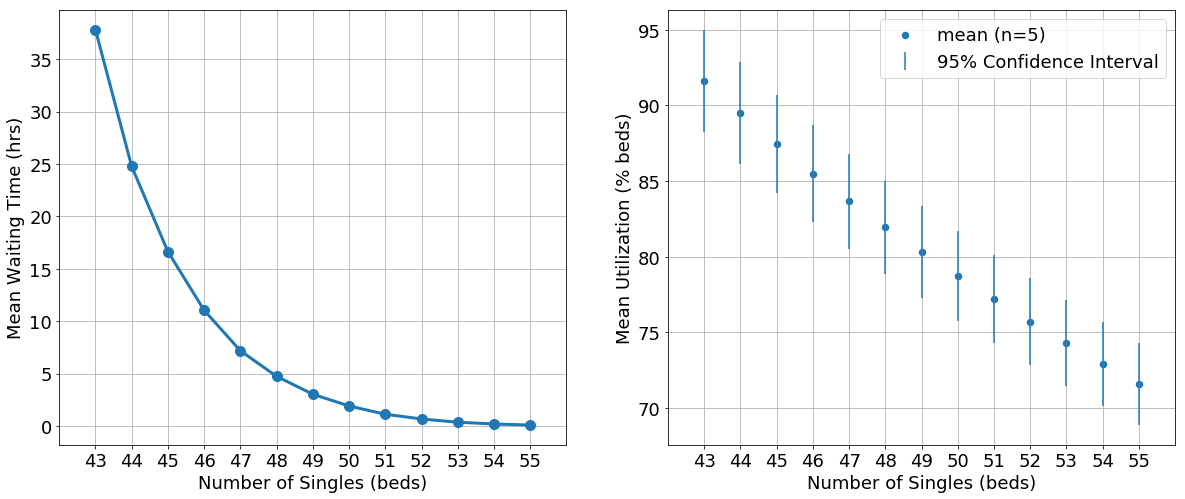

In [8]:
fig = wm.ward_model_charts(DESIGN, df_wait, df_util, df_tran)
#fig.savefig("chance_constraint_stage1.pdf", format='pdf', dpi=600, bbox_inches='tight')

### Stage 1: Limit to systems that satisfy chance constraints

#### Chance constraint 1:  Utilisation Threshold (value for money)

This is handled by the `constraints_bootstrap()` function.  This must be called for each chance constraint.  So if there are two chance constraints it must be called twice.

In [9]:
help(constraints_bootstrap)

Help on function constraints_bootstrap in module bootcomp.bootstrap:

constraints_bootstrap(data, threshold, nboots=1000, gamma=0.95, kind='lower', cores='single')
    Bootstrap a chance constraint for k systems and filter out systems
    where p% of resamples are greater a threshold t.
    
    Example 1. A lower limit.  If the chance constaint was related to
    utilization it could be stated as filter out any systems where 95% of
    the distribution is greater than 80%.
    
    Example 2. An upper limit.  If the chance constraint related to unwanted
    ward transfers it could be stated as filter out any systems
    where 95% of the distribution is less than 50 transfers per annum.
    
    Returns a pandas.Series containing of the feasible systems
    i.e. that do not violate the chance constraint.
    
    Keyword arguments:
    data -- a numpy array of the data to bootstrap
    threshold -- the threshold of the chance constraint
    n_boots -- the number of bootstrap datasets t

The function below is a convenient way to run chance contraints bootstrap for the 2 constraints.  It can be reused at stage 2.

In [10]:
def constraint_bootstrap_ward_problem(take_forward, df_u, df_t, gamma, 
                                      nboots=1000, cores='s'):
    """
    run constraints bootstrap for both chance contraints.  
    Return subset of systems that meets both constraints gamma% of the time.
    Just used for cleaner code.
    
    Keyword arguments:
    take_forward -- systems to test
    df_u -- dataframe containing replications of utilisation measure
    df_t -- dataframe containing replpications of patient transfers measure
    gamma -- test criterion e.g. 0.7, 0.8
    cores - single or parallel execution (default = 's')
    
    """
    passed_1 = constraints_bootstrap(data=df_u.values.T, 
                                     threshold=min_util, nboots=nboots, 
                                     gamma=gamma, cores=cores)
    print(f"Systems meeting MIN Utilisation constraint: {passed_1.shape[0]}")
    
    passed_2 = constraints_bootstrap(data=df_t.values.T, 
                                     threshold=max_tran, nboots=nboots, 
                                     gamma=gamma, kind='upper', cores=cores)
    print(f"Systems meeting MAX Patient Transfers constraint: {passed_2.shape[0]}")
          
    mapped_1 = np.array([take_forward[x] for x in passed_1])
    mapped_2 = np.array([take_forward[x] for x in passed_2])
    
    subset = np.intersect1d(mapped_1, mapped_2)
    print(f"Systems meeting ALL constraints: {subset.shape[0]}")
    
    return subset

If you wish to conduct a larger number of bootstraps or if the dataset is large then you may wish to
set the cores='p'

In [11]:
#to reproduce bootstrap results
np.random.seed(42)

#%%time
subset = constraint_bootstrap_ward_problem([i for i in range(df_wait.shape[1])], df_util, 
                                           df_tran, gamma_1, nboots=N_BOOTS,cores='s')

Systems meeting MIN Utilisation constraint: 428
Systems meeting MAX Patient Transfers constraint: 798
Systems meeting ALL constraints: 175


List and rank the systems along with their peformance measures

In [12]:
best_system_index, subset_kpi = get_best_subset([df_wait, df_util, df_tran], ['wait', 'util', 'tran'], subset)
best_system_index

358

### Stage 1: Quality Bootstrap 

Define set $J$ where y% of bootstraps are within x% of the best mean

This is handled by the `quality_bootstrap()` function.  This function is need only be called once per stage.


In [13]:
help(quality_bootstrap)

Help on function quality_bootstrap in module bootcomp.bootstrap:

quality_bootstrap(feasible_systems, headers, best_system_index, alpha=0.95, beta=0.1, nboots=1000, cores='s')
    1. Create differences of systems from best system
    2. Create nboots bootstrap datasets of the differences
    3. Return a DataFrame with all systems that are x% of
       feasible_systems[best_system_index] in y% of the boostrap samples
    
    Keyword arguments:
    feasible_systems -- systems that meet chance constraints
                        (if there are any)
    
    headers -- list of system indexes that are feasible
    
    best_system_index -- index of the best system within @feasible_systems
    
    alpha -- % of boostrap samples that must be within tolerance x of
            best mean (default = 0.95)
    
    beta -- % tolerance of difference from best mean allowed (default = 0.1)
    
    nboots = number of bootstrap datasets to create (default = 1000)
    
    cores - single ('single' or 

In [14]:
#to reproduce bootstrap results
np.random.seed(1985)

feasible_systems = df_wait[subset]
take_forward = quality_bootstrap(feasible_systems, subset, best_system_index, 
                                 nboots=N_BOOTS, alpha=y_1, beta=x_1)

In [15]:
no_stage1 = take_forward.shape[0]
no_stage1

37

_Quick look at stage 1 results_

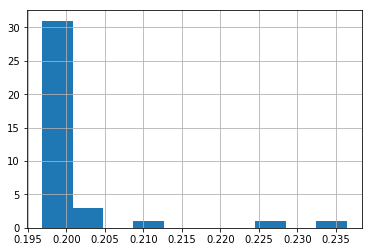

In [16]:
best_subset_table(subset_kpi, take_forward, DESIGN)['wait'].hist()

## 4. Procedure - Stage 2

### More replicates of promising solutions using Common Random Numbers

User simulates $ n_2 $ additional replicates for the feasible solutions brought forward from stage 1.

Example = 50 replicates (45 extra)

In [17]:
df_wait_s2, df_util_s2, df_tran_s2 = wm.simulate_stage_2(take_forward, load_model_file(MODEL_PATH))

Loaded waiting time data. 37 systems; 50 replications
Loaded utilzation data. 37 systems; 50 replications
Loaded transfers data. 37 systems; 50 replications


### Stage 2 Constraints Bootstrap

In [18]:
#to reproduce bootstrap results
np.random.seed(1966)
subset = constraint_bootstrap_ward_problem(take_forward, df_util_s2, df_tran_s2, gamma_2)

Systems meeting MIN Utilisation constraint: 37
Systems meeting MAX Patient Transfers constraint: 36
Systems meeting ALL constraints: 36


In [19]:
best_system_index, subset_kpi = get_best_subset([df_wait_s2, df_util_s2, df_tran_s2], 
                                                ['wait', 'util', 'tran'], subset)
best_system_index

403

### Stage 2 Quality Bootstrap

In [20]:
#to reproduce bootstrap results
np.random.seed(101)

feasible_systems = df_wait_s2[subset]
final_set = quality_bootstrap(feasible_systems, subset, best_system_index, 
                              nboots=N_BOOTS, alpha=y_2, beta=x_2)
final_set.shape

(28,)

## Visualise Final Solution

In [23]:
df_final = best_subset_table(subset_kpi, final_set, DESIGN)
df_final.sort_values(['Size of Bays', 'Number of Bays'], ascending=True)[:10]

,Total beds,Size of Bays,Number of Bays,Number of Singles,wait,util,tran
352,48,0,0,48,0.204245,81.011717,0.00
353,48,3,3,39,0.204245,81.011717,12.72
354,48,3,4,36,0.204245,81.011717,16.54
355,48,3,5,33,0.204245,81.011717,20.86
356,48,3,6,30,0.204294,81.011717,25.40
357,48,3,7,27,0.204609,81.012289,29.94
358,48,3,8,24,0.205050,81.014004,35.30
359,48,3,9,21,0.206137,81.012289,40.22
367,48,4,2,40,0.204245,81.011717,12.46
368,48,4,3,36,0.204245,81.011717,17.32
